In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
plt.style.use("dark_background")

### Fetching data:

In [2]:
X, y = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=1234)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

### Displaying data on 2D plane:

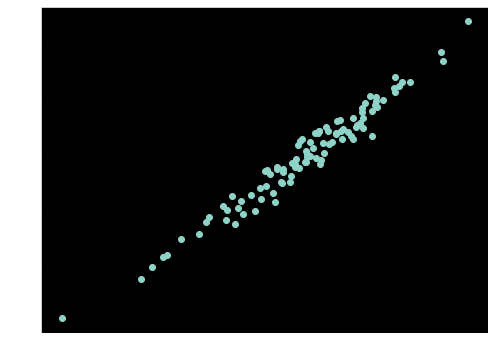

In [3]:
fig=plt.figure(figsize=(8,6))
plt.scatter(X[:,0],y)
plt.show()

on X axis -> independent variables values, 
on Y axis -> dependent variable values

##### Appending 1 to each instance/data point in order to calculate bias:

In [4]:
X_train_augmented = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_train_augmented

array([[ 1.00000000e+00,  3.61419367e-02],
       [ 1.00000000e+00,  9.84919842e-01],
       [ 1.00000000e+00,  1.82891913e-02],
       [ 1.00000000e+00, -1.22091575e-01],
       [ 1.00000000e+00,  2.15268581e-01],
       [ 1.00000000e+00, -1.19097569e+00],
       [ 1.00000000e+00, -3.12651896e-01],
       [ 1.00000000e+00,  5.65738306e-01],
       [ 1.00000000e+00,  2.00784295e+00],
       [ 1.00000000e+00,  3.07968855e-01],
       [ 1.00000000e+00,  1.15003572e+00],
       [ 1.00000000e+00,  1.39198619e+00],
       [ 1.00000000e+00, -2.02646325e-01],
       [ 1.00000000e+00,  1.64529543e-01],
       [ 1.00000000e+00, -9.74236334e-01],
       [ 1.00000000e+00,  3.95126867e-02],
       [ 1.00000000e+00,  6.31979446e-01],
       [ 1.00000000e+00,  1.04593826e+00],
       [ 1.00000000e+00,  2.11883387e-01],
       [ 1.00000000e+00, -3.56351666e+00],
       [ 1.00000000e+00,  7.67368736e-01],
       [ 1.00000000e+00,  1.43270697e+00],
       [ 1.00000000e+00,  1.93421376e-01],
       [ 1.

In [5]:
X_train_T = X_train_augmented.T

### Data Encryption and storing on cloud:

In [6]:
import tenseal as ts
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
context.generate_galois_keys()
context.global_scale = 2**40

In [7]:
X_train_T

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+0

In [8]:
enc_X_train=[]
for i in X_train_T:
    p=ts.ckks_vector(context,i)
    enc_X_train.append(p)

In [9]:
enc_y_train=ts.ckks_vector(context,y_train)

### SERVER SIDE CODE:

In [10]:
enc_X_1=enc_X_train

In [11]:
XTX=[]
for i in enc_X_train:
    row_in=[]
    for j in enc_X_1:
        p=i.dot(j)
        row_in.append(p)
    XTX.append(row_in)

In [12]:
XTY=[]
for i in enc_X_train:
    p=i.dot(enc_y_train)
    XTY.append(p)

### CLIENT SIDE CALCULATIONS:

In [13]:
XTX_dec=[]
for i in XTX:
    row_in=[]
    for j in i:
        p=j.decrypt()
        row_in.append(p[0])
    XTX_dec.append(row_in)

XTX_dec_1 = np.array(XTX_dec)
XTX_dec_1

array([[80.00000904,  1.24954952],
       [ 1.24954952, 82.88461672]])

In [14]:
XTY_dec=[]
for i in XTY:
    p=i.decrypt()
    XTY_dec.append(p[0])

XTY_dec_1 = np.array(XTY_dec)
XTY_dec_1

array([ 182.82936692, 7245.81387877])

In [15]:
XTX_inv = np.linalg.inv(XTX_dec_1)
theta = np.dot(XTX_inv, XTY_dec)

In [16]:
bias = theta[0]
weights = theta[1:]

### OBTAINED VALUES:

In [17]:
bias

0.9201307410137328

In [18]:
weights

array([87.40661918])

### Testing:

In [19]:
enc_X_test=[]
for i in X_test:
    p=ts.ckks_vector(context,i)
    enc_X_test.append(p)

In [20]:
predictions=[]
for i in enc_X_test:
    t=i.dot(weights)
    t=t+bias
    predictions.append(t.decrypt()[0])

### Comparing actual values with Predicted values:

In [21]:
for a,b in zip(y_test,predictions):
    print(a,b)

-6.400439740897028 22.57881206552507
-75.83288846408419 -54.716244275649814
43.02438482670904 41.51109945854911
81.72162477765585 87.62279056279252
-197.9801503584435 -195.10540541928643
32.09705138165424 49.294361321988674
-102.66748011552487 -77.49732120267187
15.35071412820563 11.820870004456758
6.892323119468568 26.1886832778231
26.28851287900197 7.580480010212662
-80.36899984455164 -80.04063809615621
30.84591703151775 62.5173862120707
95.06862969774186 78.46405433966052
69.43879729019481 62.4743473625705
-45.80868282540775 -29.214704951308562
63.18804079600157 42.12669008389426
91.41603362148403 91.28116985673495
-108.37740214379002 -121.62163047514838
142.75464960351508 116.3935217350378
87.77205622112535 74.42987609824604


### Calculating Mean Square Error of Predicted Values:

In [22]:
def mse(y_test, enc_predictions):
    return np.mean((y_test-enc_predictions)**2)

mse = mse(y_test,predictions)
print(mse)

304.49341456037354


### Displaying Predicted vs Actual Values on 2D plane:

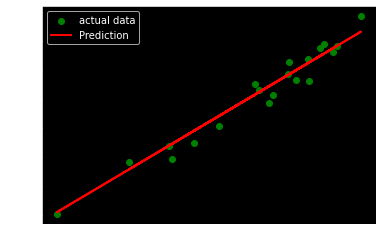

In [23]:
plt.scatter(X_test,y_test,color='green',label='actual data')
plt.plot(X_test,predictions,color='red',linewidth=2,label='Prediction')
plt.legend()
plt.show()